In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #(Augmented Dickey-Fuller test)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
tesla_df = pd.read_csv("/content/Tesla Stock Dataset.csv")
tesla_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [3]:
print(tesla_df.describe())
print(tesla_df.info())

         Adj Close        Close         High          Low         Open  \
count  3654.000000  3654.000000  3654.000000  3654.000000  3654.000000   
mean     81.695980    81.695980    83.507689    79.793275    81.707033   
std     107.839958   107.839958   110.325408   105.251783   107.891905   
min       1.053333     1.053333     1.108667     0.998667     1.076000   
25%      12.098500    12.098500    12.371166    11.821833    12.164833   
50%      17.936666    17.936666    18.221666    17.679000    17.964667   
75%     177.992496   177.992496   182.605000   174.707504   178.017502   
max     479.859985   479.859985   488.540009   457.510010   475.899994   

             Volume  
count  3.654000e+03  
mean   9.667827e+07  
std    7.770996e+07  
min    1.777500e+06  
25%    4.899450e+07  
50%    8.203705e+07  
75%    1.223769e+08  
max    9.140820e+08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 7 columns):
 #   Column     Non-Null Coun

In [4]:
# Convert the Date column to a datetime format and set it as the index.
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
tesla_df.set_index('Date', inplace=True)

In [5]:
#Select the close column for analysis
close_data = tesla_df['Close']
close_data.dropna()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-12-27,431.660004
2024-12-30,417.410004
2024-12-31,403.839996


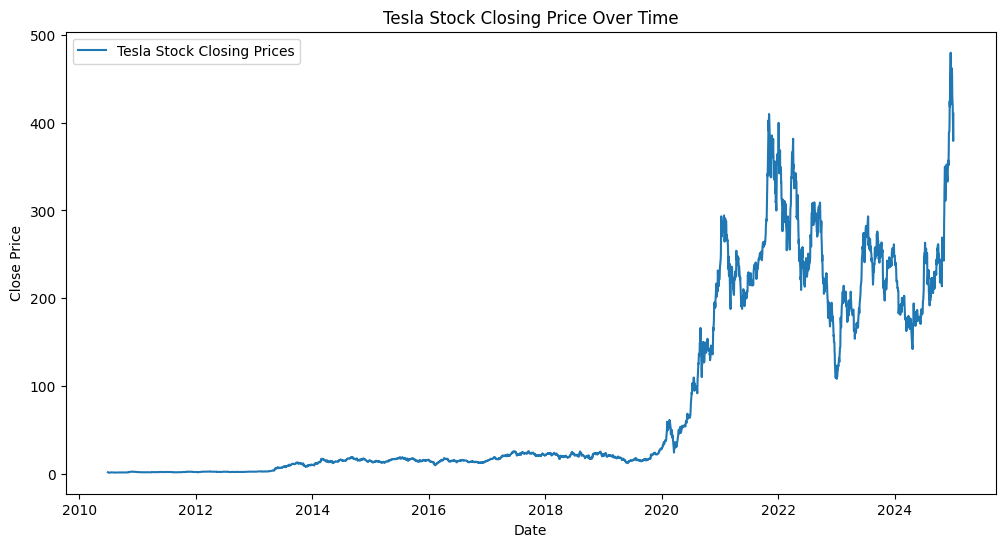

In [6]:
#Plot the time series
plt.figure(figsize=(12,6))
plt.plot(close_data, label='Tesla Stock Closing Prices')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**Decompose The Time Series**

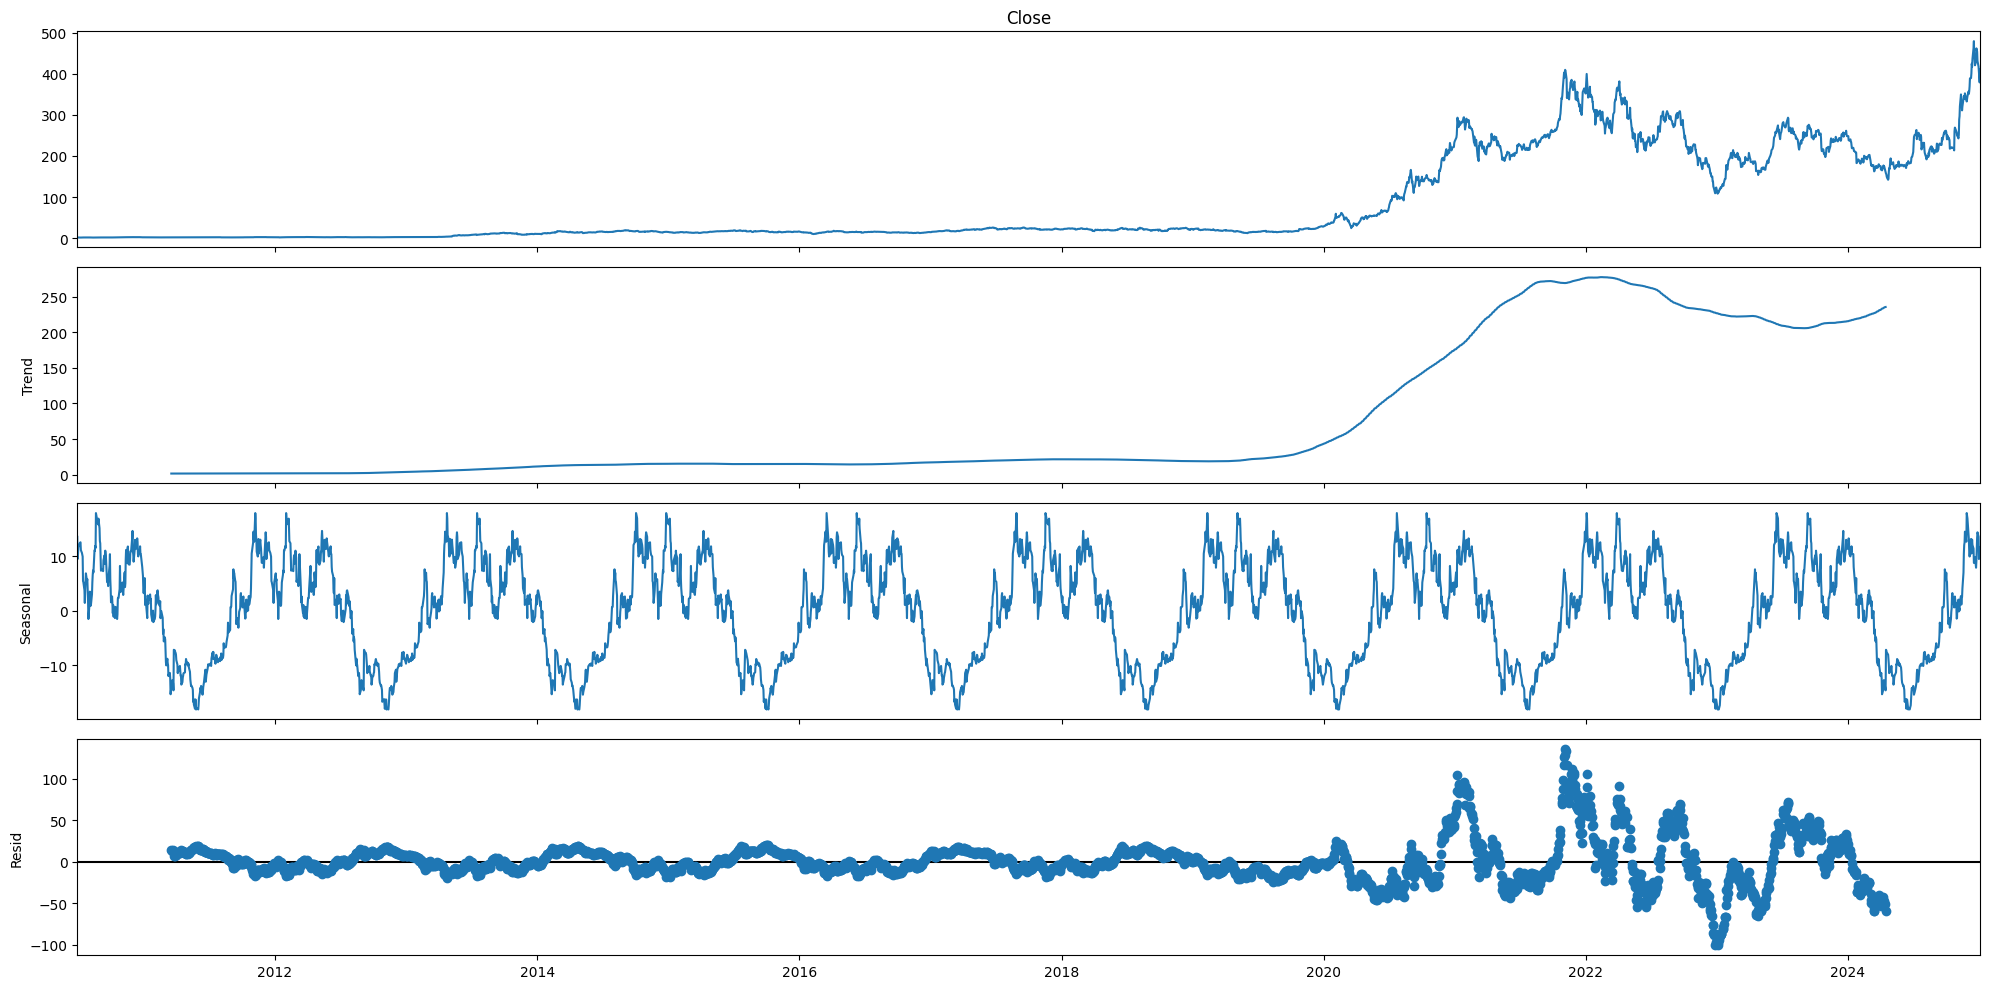

In [7]:
#decompose the time series to observe the trends, seasonality and residuals
decomposition = seasonal_decompose(close_data, model='additive', period=365)
#plot the decomposition
plt.rcParams['figure.figsize'] = (20, 10)  # Adjust width and height as desired
decomposition.plot()
plt.show()

**Test For Stationarity**

In [8]:
#perform Augmented Dicky Fuller Test
result = adfuller(close_data)
print("ADF Statistic", result[0])
print("Print P value", result[1])
print("Critical Values", result[4])

#interpret the results
if result[1] <= 0.05:
  print("Time Series Data is Stationary")
else:
  print("Time Series Data is Non-Stationary, Differencing is required")

ADF Statistic -0.050115782672356196
Print P value 0.9541860444166191
Critical Values {'1%': np.float64(-3.4321552239077326), '5%': np.float64(-2.8623376471853903), '10%': np.float64(-2.5671945999714625)}
Time Series Data is Non-Stationary, Differencing is required


**Differencing The Data**

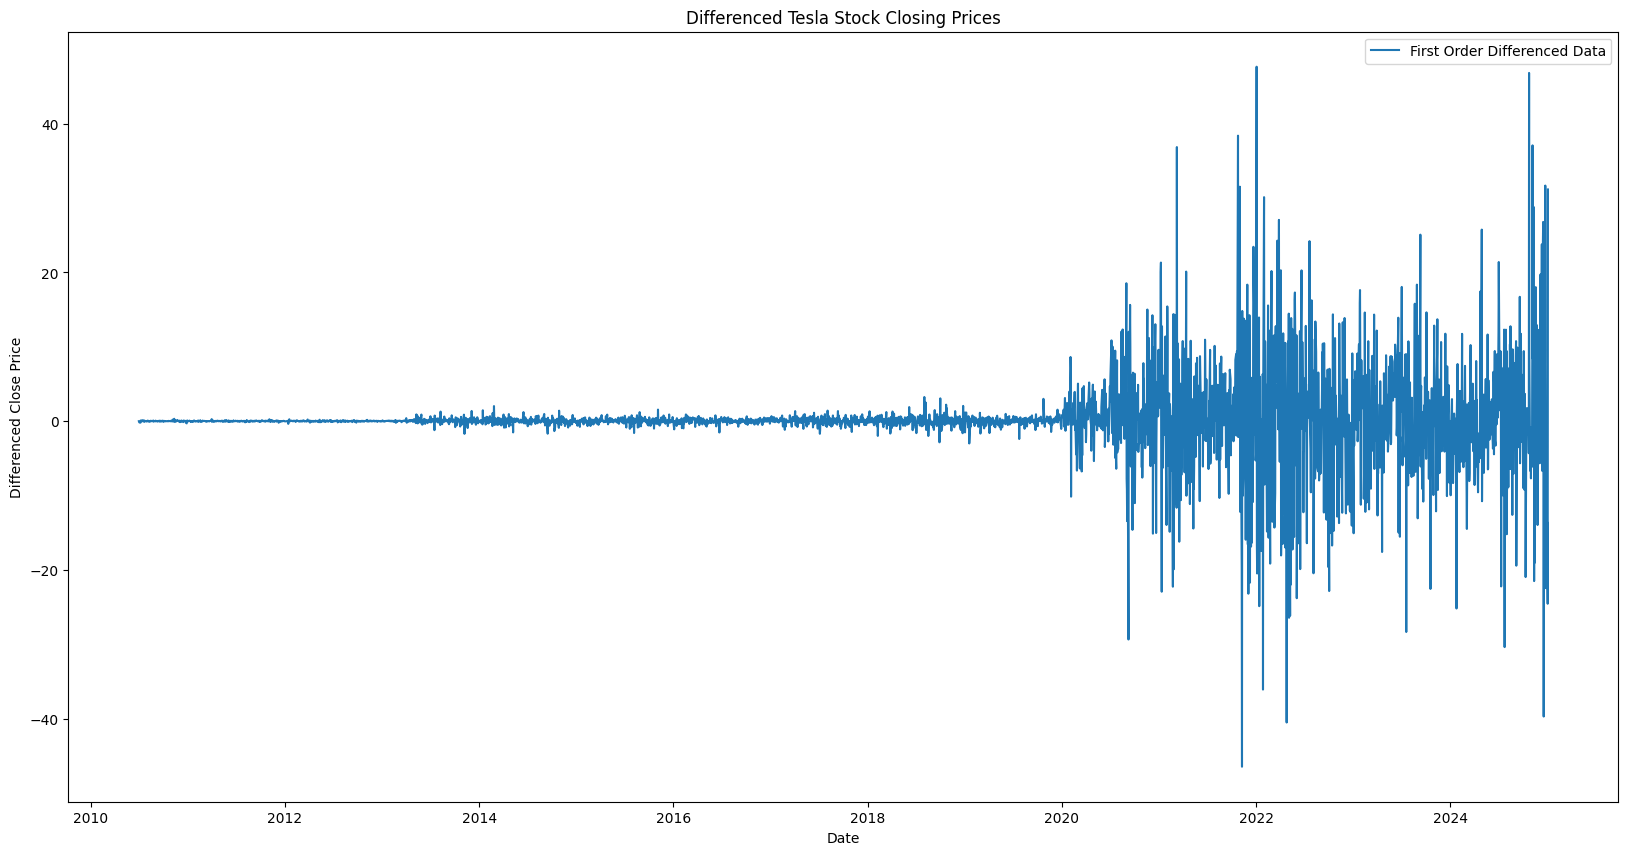

In [9]:
#Apply first-order differencing
data_diff = close_data.diff()

#plot the differenced data
plt.plot(data_diff, label='First Order Differenced Data')
plt.title('Differenced Tesla Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()


Differencing is a time series preprocessing technique used to make a time series stationary.

In [10]:
#apply adfuller test to check the stationary of differenced data
diff = adfuller(data_diff.dropna())
print("ADF Statistic", diff[0])
print("Print P value", diff[1])
print("Critical Values", diff[4])

#interpret the results
if diff[1] <= 0.05:
  print("Data is Stationary.")
else:
  print("Data is Non-Stationary, Differencing is required")

ADF Statistic -10.29547932315681
Print P value 3.4803426213447984e-18
Critical Values {'1%': np.float64(-3.4321567201852456), '5%': np.float64(-2.862338308122449), '10%': np.float64(-2.5671949518327932)}
Data is Stationary.


Finally, We have Stationary dataset. Now we can move on to next step, which is ACf and PACF plots.

**ACF AND PACF PLOTS**

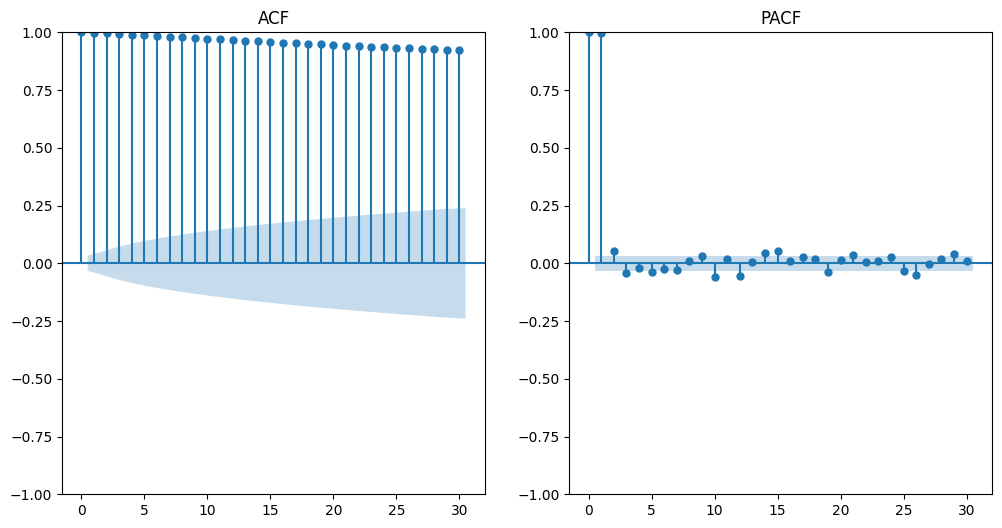

In [11]:
#plot ACF and PACF on original data
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(close_data, ax=ax[0], lags=30, title='ACF')
plot_pacf(close_data, ax=ax[1], lags=30, title='PACF')
plt.show()

It suggests The original data had autocorrelations, but they were removed by differencing.

**Training & Testing¶**

In [12]:
# Split data into training and testing sets
train_data = close_data[:int(0.8 * len(close_data))]  # 80% for training
test_data = close_data[int(0.8 * len(close_data)):]    # 20% for testing

**Build the ARIMA Model**

In [13]:
# Build and fit the ARIMA model
model = ARIMA(train_data, order=(5, 1, 0)) #Order (p, d, q)
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(close_data)-1)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 95.016


In [14]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2923
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7849.400
Date:                Wed, 09 Apr 2025   AIC                          15710.799
Time:                        07:12:39   BIC                          15746.680
Sample:                             0   HQIC                         15723.723
                               - 2923                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0349      0.006     -5.820      0.000      -0.047      -0.023
ar.L2         -0.0266      0.005     -4.849      0.000      -0.037      -0.016
ar.L3          0.0440      0.007      5.876      0.0

**Forecast  Future Prices**

In [16]:
# Example: Forecast the next 30 days
forecast_steps = 30
ARIMA_forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean


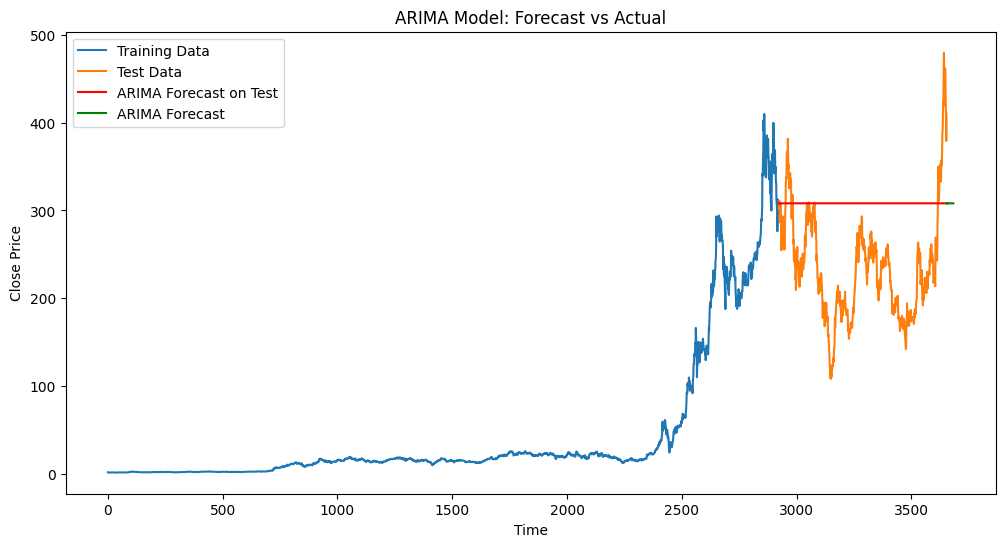

In [24]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label='Training Data')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), predictions, label='ARIMA Forecast on Test', color='red')
#Plot of predictions on test data
plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + forecast_steps), ARIMA_forecast, label='ARIMA Forecast', color='green')
#Plot of forecasted values
plt.title('ARIMA Model: Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()